In [1]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.CRITICAL)

In [2]:
import nltk
# nltk.download("stopwords")
# nltk.download("wordnet")

In [3]:
import pandas as pd
tweets_csv = pd.read_csv("data/twcs.csv")
tweets_csv.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [4]:
import numpy as np

tweets = tweets_csv.copy()

first_mask = tweets.in_response_to_tweet_id.isnull()
first_tweet_ids = tweets.loc[first_mask, "tweet_id"].values
tweet_conversation = pd.DataFrame({"tweet_id": first_tweet_ids, 
                                   "conversation_id": np.arange(first_tweet_ids.size) + 1}, 
                                  dtype="int64")

unmatched_tweets = tweets.loc[~first_mask, ["tweet_id", "in_response_to_tweet_id"]].astype("int64")

results = tweet_conversation.copy()

while not tweet_conversation.empty:
    merged = pd.merge(unmatched_tweets, tweet_conversation, how="left", left_on="in_response_to_tweet_id", right_on="tweet_id", 
                      suffixes=("", "_parent"))
    matched_mask = merged.tweet_id_parent.notnull()
    tweet_conversation = merged.loc[matched_mask, tweet_conversation.columns]
    results = results.append(tweet_conversation.copy(), ignore_index=True)
    unmatched_tweets = merged.loc[~matched_mask, unmatched_tweets.columns]

results["conversation_id"] = results.conversation_id.astype("int64")

tweets = pd.merge(tweets, results, on="tweet_id")

channels = tweets[~tweets.author_id.str.match(r"[0-9]+$")].groupby("conversation_id")["author_id"].first().to_frame("channel")
tweets = pd.merge(tweets, channels, left_on="conversation_id", right_index=True)

tweets.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,conversation_id,channel
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0,1,sprintcare
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,1,sprintcare
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,1,sprintcare
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0,1,sprintcare
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,1,sprintcare


In [92]:
tweets.groupby("channel").count().sort_values("conversation_id", ascending=False)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,conversation_id
channel,,,,,,,,
AmazonHelp,370222,370222,370222,370222,370222,251311,288378,370222
AppleSupport,237443,237443,237443,237443,237443,149034,157129,237443
Uber_Support,127801,127801,127801,127801,127801,78613,86038,127801
SpotifyCares,91459,91459,91459,91459,91459,58757,63278,91459
Delta,86553,86553,86553,86553,86553,50899,60595,86553
AmericanAir,85822,85822,85822,85822,85822,54815,59757,85822
TMobileHelp,79242,79242,79242,79242,79242,49899,56762,79242
Tesco,71824,71824,71824,71824,71824,39682,55236,71824
comcastcares,71468,71468,71468,71468,71468,42432,47660,71468


In [93]:
channel_tweets = tweets[tweets.channel == "AskSeagate"].groupby("conversation_id")["text"].apply(lambda s: s.str.cat(sep=" "))
channel_tweets.head()

conversation_id
3385     @119615 Unfortunately, the .nbi files cannot b...
15117    @132587 Hello Joey,\n\nWe are sorry that your ...
15118    @132588 Hello Krista,\n\nUnfortunately we don'...
21238    @139188 Try the number zero instead of the let...
21239    @139189 If you have come to the conclusion tha...
Name: text, dtype: object

In [94]:
from nltk.tokenize import RegexpTokenizer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from collections import defaultdict
from gensim.corpora import Dictionary

tokenizer = RegexpTokenizer(r"\w+")
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english'))
url_pattern = re.compile(r"https\:\/\/t\.co\/[a-zA-Z0-9]+")
num_pattern = re.compile(r"[0-9]+$")

def get_cleaned_doc(doc):
    cleaned = url_pattern.sub("?", doc)
    cleaned = cleaned.lower()
    cleaned = tokenizer.tokenize(cleaned)
    cleaned = [word for word in cleaned if num_pattern.match(word) is None]
    cleaned = [lemmatizer.lemmatize(word) for word in cleaned]
    cleaned = [word for word in cleaned if word not in stop]
    return cleaned


In [95]:
docs = [get_cleaned_doc(doc) for doc in channel_tweets]

token_freq = defaultdict(int)
for doc in docs:
    for token in doc:
        token_freq[token] += 1

print("number of unique tokens: " + str(len(token_freq)))
print("tokens used only once: " + str(sum(freq == 1 for freq in token_freq.values())))

# docs = [[token for token in doc if token_freq[token] > 1] for doc in docs]

dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=2, keep_n=None)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in docs]

number of unique tokens: 2488
tokens used only once: 1206


In [96]:
from gensim.models.tfidfmodel import df2idf

token_imp = defaultdict(int)
for token, _ in dictionary.token2id.items():
    token_id = dictionary.token2id[token]
    freq = token_freq[token]
    token_imp[token] = freq * df2idf(dictionary.dfs[token_id], len(doc_term_matrix))


In [87]:
all_conversations = tweets.groupby("conversation_id")["text"].apply(lambda s: s.str.cat(sep=" "))
all_docs = [get_cleaned_doc(doc) for doc in all_conversations]
all_dictionary = Dictionary(all_docs)


In [152]:
token_imp2 = defaultdict(int)
for token, _ in dictionary.token2id.items():
    token_id = all_dictionary.token2id[token]
    freq = token_freq[token]
    token_imp2[token] = freq * df2idf(all_dictionary.dfs[token_id], len(all_conversations))

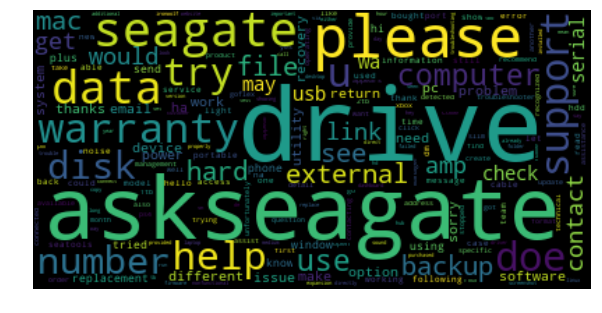

In [97]:
from wordcloud import WordCloud

word_cloud = WordCloud().generate_from_frequencies(token_freq)

import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(10, 10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off");


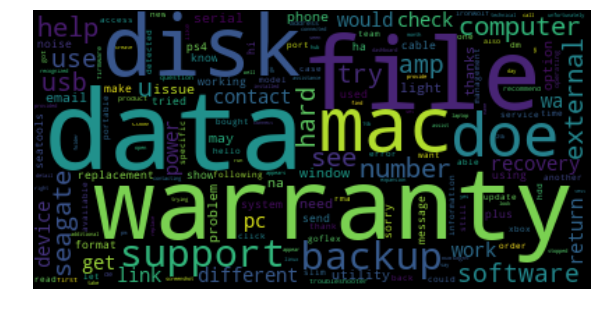

In [98]:
word_cloud = WordCloud().generate_from_frequencies(token_imp)

plt.figure(figsize=(10, 10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off");

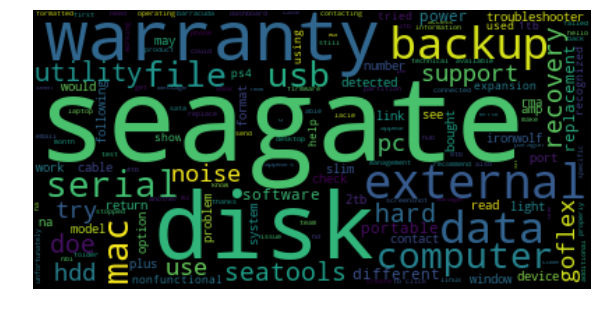

In [154]:
word_cloud = WordCloud().generate_from_frequencies(token_imp2)

plt.figure(figsize=(10, 10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off");

In [155]:
weighted_corpus = [[(token_id, freq * df2idf(all_dictionary.dfs[token_id], len(all_conversations))) for token_id, freq in doc_bow] 
                   for doc_bow in doc_term_matrix]

In [ ]:
from gensim.models import LdaModel

logging.getLogger().setLevel(logging.DEBUG) # checking convergence
lda = LdaModel(weighted_corpus, id2word=dictionary, num_topics=10, alpha='auto', iterations=400, passes=3)
logging.getLogger().setLevel(logging.CRITICAL)

In [183]:
import random
from gensim.models import LdaModel, LdaMulticore, CoherenceModel

def eval_config(corpus, texts, n_topics, k=10, iterations=100, passes=1, multicore=False):
    def get_lda_model(train_corpus):
        if multicore:
            return LdaMulticore(train_corpus, id2word=dictionary, num_topics=n_topics, iterations=iterations, passes=passes)
        return LdaModel(train_corpus, id2word=dictionary, num_topics=n_topics, alpha='auto', iterations=iterations, passes=passes)
    
    random.shuffle(corpus)
    perps = []
    for i in range(k):
        val_from = round(i / k * len(corpus)) if k > 1 else 0
        val_to = round((i + 1) / k * len(corpus)) if k > 1 else 0
        train = corpus[:val_from] + corpus[val_to:]
        val = corpus[val_from:val_to]
        
        lda = get_lda_model(train)
        perps.append(lda.log_perplexity(val if k > 1 else train))
        print("fold " + str(i + 1) + "/" + str(k) + " finished")
    
    lda = get_lda_model(corpus)
    umass = CoherenceModel(model=lda, corpus=corpus, coherence='u_mass')
    cv = CoherenceModel(model=lda, texts=texts, coherence='c_v')
    
    return (np.mean(perps), np.std(perps), umass.get_coherence(), cv.get_coherence(), lda)

In [ ]:
topic_values = [2, 5, 10, 25, 50, 100]
results = [eval_config(weighted_corpus, docs, n_topics, iterations=400, passes=3) for n_topics in topic_values]

In [186]:
pd.DataFrame({"n_topics": topic_values, 
              "mean perplexity": [result[0] for result in results], 
              "perplexity sd": [result[1] for result in results], 
              "umass": [result[2] for result in results], 
              "c_v": [result[3] for result in results]})

,c_v,mean perplexity,n_topics,perplexity sd,umass
0,0.275125,-6.902511,2,0.085689,-1.789753
1,0.275169,-7.315663,5,0.121403,-2.046204
2,0.297114,-7.861995,10,0.110800,-3.208871
3,0.293352,-9.070390,25,0.260991,-4.131546
4,0.341151,-10.169175,50,0.426049,-5.266646
5,0.360721,-11.966251,100,0.872926,-5.664420


In [187]:
import pyLDAvis.gensim

# lda = results[0][4]
lda = LdaModel(weighted_corpus, id2word=dictionary, num_topics=2, alpha='auto', iterations=400, passes=3)

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, weighted_corpus, dictionary, mds="tsne")

PreparedData(topic_coordinates=            Freq  cluster  topics            x           y
topic                                                     
0      60.428589        1       1  2352.815430 -5514.87207
1      39.571407        1       2 -2352.815186  5514.87207, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
76    Default  2094.000000     warranty  2094.000000  30.0000  30.0000
197   Default   511.000000          ps4   511.000000  29.0000  29.0000
42    Default   957.000000       number   957.000000  28.0000  28.0000
38    Default   600.000000           ha   600.000000  27.0000  27.0000
91    Default   270.000000         come   270.000000  26.0000  26.0000
48    Default   481.000000       serial   481.000000  25.0000  25.0000
699   Default   163.000000         bios   163.000000  24.0000  24.0000
206   Default   459.000000           dm   459.000000  23.0000  23.0000
158   Default   239.000000        noise   239.000000  22.0000  22.0000
525   Default   231.000000     seatools   231.000000  21.0000  21.0000
241   Default   392.000000    available   392.000000  20.0000  20.0000
523   Default   131.000000  reallocated   131.000000  19.0000  19.0000
385   Default   253.000000      website   253.000000  18.0000  18.0000
328   Default   474.000000        email   474.000000  17.0000  17.0000
852   Default   101.000000          ssd   101.000000  16.0000  16.0000
24    Default  1039.000000      support  1039.000000  15.0000  15.0000
526   Default   102.000000       sector   102.000000  14.0000  14.0000
755   Default   111.000000  performance   111.000000  13.0000  13.0000
653   Default   311.000000           pm   311.000000  12.0000  12.0000
423   Default   203.000000       folder   203.000000  11.0000  11.0000
758   Default    81.000000        speed    81.000000  10.0000  10.0000
309   Default   451.000000         read   451.000000   9.0000   9.0000
372   Default   129.000000      process   129.000000   8.0000   8.0000
90    Default   321.000000        check   321.000000   7.0000   7.0000
764   Default   167.000000    dashboard   167.000000   6.0000   6.0000
424   Default   238.000000    formatted   238.000000   5.0000   5.0000
490   Default   101.000000          4tb   101.000000   4.0000   4.0000
117   Default   400.000000       return   400.000000   3.0000   3.0000
108   Default   257.000000        light   257.000000   2.0000   2.0000
83    Default    67.000000      adapter    67.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
76     Topic2  1133.395996     warranty  2094.779297   0.3128  -3.5896
48     Topic2   322.164856       serial   481.974121   0.5242  -4.8475
241    Topic2   264.236298    available   392.474304   0.5314  -5.0457
206    Topic2   299.042664           dm   459.713745   0.4970  -4.9220
645    Topic2    80.703514         dead    96.747543   0.7457  -6.2318
653    Topic2   203.350906           pm   311.400085   0.5009  -5.3077
328    Topic2   281.118530        email   474.837952   0.4029  -4.9838
24     Topic2   503.652100      support  1039.230591   0.2027  -4.4007
424    Topic2   159.577133    formatted   238.879395   0.5236  -5.5501
187    Topic2   771.810486        would  1920.723633   0.0153  -3.9738
309    Topic2   255.354538         read   451.220642   0.3578  -5.0799
90     Topic2   197.560699        check   321.957489   0.4387  -5.3365
446    Topic2   362.293793          let   748.575806   0.2013  -4.7301
117    Topic2   229.715240       return   400.625793   0.3709  -5.1857
108    Topic2   165.682724        light   257.393158   0.4865  -5.5125
151    Topic2   488.950958         hard  1268.064087  -0.0259  -4.4303
77     Topic2   267.914246         work   543.843872   0.2191  -5.0319
215    Topic2   208.800995         case   379.508240   0.3296  -5.2812
44     Topic2   266.454071      problem   569.553345   0.1674  -5.0374
115    Topic2   292.087891   

In [307]:
from gensim.matutils import corpus2dense

def wlocal(tf):
    return 1 if tf > 0 else 0

def wglobal(df, total_docs):
    return 1

tfidf = TfidfModel(doc_term_matrix, dictionary=dictionary, smartirs="bnc")
weighted_corpus = tfidf[doc_term_matrix]


dense_corpus = corpus2dense(weighted_corpus, len(dictionary)).T
# dense_corpus = dense_corpus / np.sum(dense_corpus**2, axis=1)[:, np.newaxis]
dense_corpus.shape

(341, 1164)

In [274]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

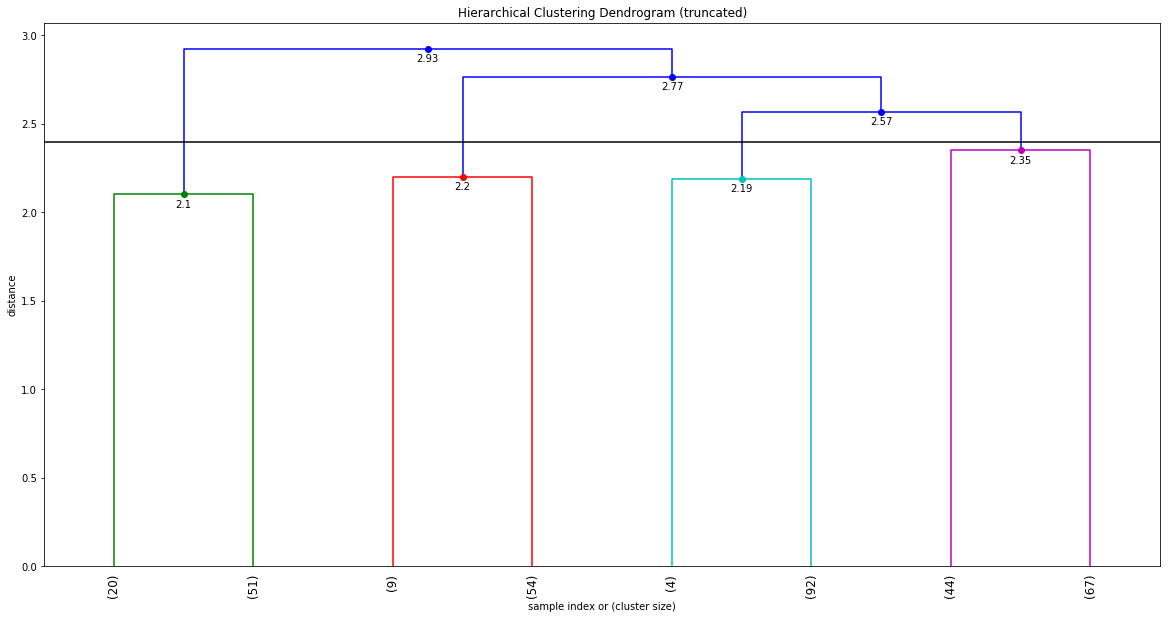

In [310]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(dense_corpus, 'ward', metric="euclidean")

plt.figure(figsize=(20, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
fancy_dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=12.,  # font size for the x axis labels
    truncate_mode = "lastp",
    p=8,
    max_d=2.4
);

TypeError: argument of type 'int' is not iterable

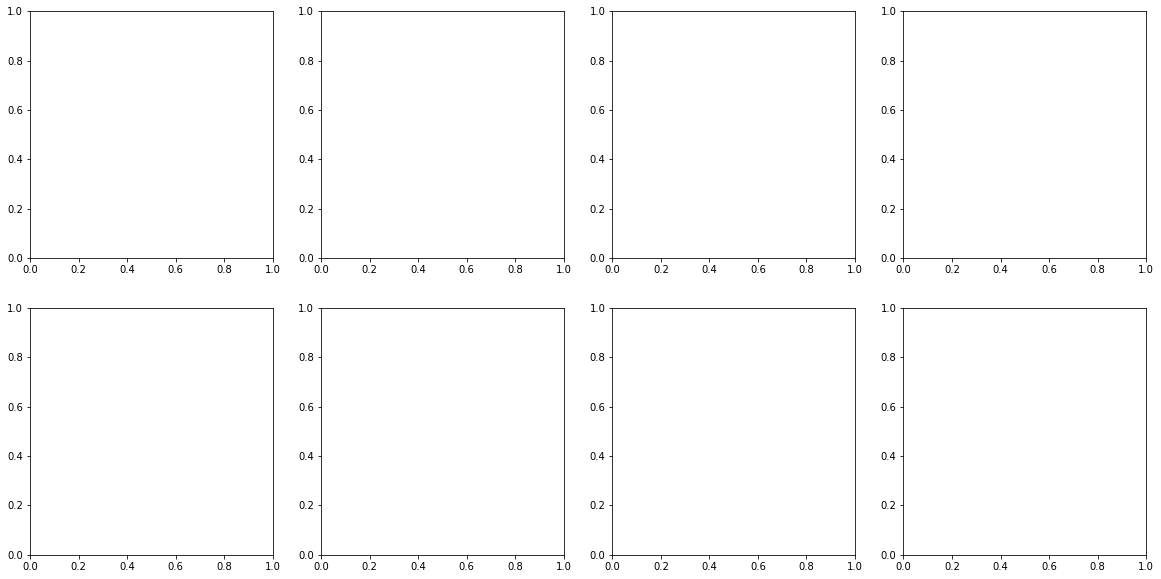

In [397]:
from scipy.cluster.hierarchy import fcluster

k = 8
clusters = fcluster(Z, k, criterion='maxclust')

clustered_docs = []

for cidx in range(k):
    cluster_indices = np.where(clusters == cidx + 1)[0]    
    clustered_docs.append([token for i, doc in enumerate(docs) if i in cluster_indices for token in doc])

clustered_dict = Dictionary(clustered_docs)
clustered_corpus = [clustered_dict.doc2bow(doc) for doc in clustered_docs]
clustered_tfidfs = [[(clustered_dict[token_id], imp) for token_id, imp in doc] for doc in tfidf[clustered_corpus]]

ncols = 4
nrows = int(k / 4)

fig, axes = plt.subplots(nrows, ncols, figsize=(20, 10))
for r in range(nrows):
    for c in range(ncols):
        token_imp = dict(clustered_tfidfs[i])
        word_cloud = WordCloud(width=1000, height=750).generate_from_frequencies(token_imp)
        axes[r, c].imshow(word_cloud, interpolation='bilinear')
        axes[r, c].axis("off");

# plt.tight_layout()


In [399]:
clustered_tfidfs[1]

[('1st', 0.0029979130206107146),
 ('1tb', 0.010492695572137502),
 ('3tb', 0.008993739061832144),
 ('5tb', 0.008993739061832144),
 ('able', 0.026981217185496432),
 ('access', 0.008993739061832144),
 ('aid', 0.005995826041221429),
 ('already', 0.0024884926462595113),
 ('also', 0.04197078228855001),
 ('always', 0.0014989565103053573),
 ('amazon', 0.0012442463231297557),
 ('amp', 0.018663694846946334),
 ('apologize', 0.0029979130206107146),
 ('appear', 0.04496869530916072),
 ('appears', 0.02997913020610715),
 ('assistance', 0.0029979130206107146),
 ('backup', 0.06895199947404644),
 ('bad', 0.0029979130206107146),
 ('beeping', 0.020985391144275004),
 ('bottom', 0.0014989565103053573),
 ('bought', 0.009331847423473167),
 ('buy', 0.0029979130206107146),
 ('cable', 0.015553079039121946),
 ('check', 0.07194991249465715),
 ('checked', 0.005995826041221429),
 ('clicking', 0.011991652082442858),
 ('compatible', 0.004496869530916072),
 ('connect', 0.006843354777213656),
 ('contact', 0.0049769852925

[[('18th', 0.02584376713636261),
  ('1st', 0.07753130140908783),
  ('1xaap3', 0.02584376713636261),
  ('200gb', 0.012921883568181304),
  ('2hc015kj', 0.02584376713636261),
  ('2nd', 0.02584376713636261),
  ('2t', 0.02584376713636261),
  ('300gb', 0.05168753427272522),
  ('3rd', 0.0053630662421103505),
  ('500gb', 0.07753130140908783),
  ('5gb', 0.012921883568181304),
  ('5tb', 0.021452264968441402),
  ('64bit', 0.02584376713636261),
  ('6tb', 0.06460941784090653),
  ('8tb', 0.016089198726331053),
  ('able', 0.058993728663213854),
  ('aborted', 0.02584376713636261),
  ('accept', 0.02584376713636261),
  ('accessible', 0.038765650704543915),
  ('accessing', 0.02584376713636261),
  ('accidentally', 0.02584376713636261),
  ('according', 0.0053630662421103505),
  ('adapter', 0.02584376713636261),
  ('add', 0.012921883568181304),
  ('addititonal', 0.02584376713636261),
  ('administrative', 0.02584376713636261),
  ('advance', 0.02584376713636261),
  ('afford', 0.02584376713636261),
  ('afp', 0

In [371]:
clustered_dict[0]

'18th'

In [319]:
np.where(clusters == 1)[0]

array([  4,   5,  10,  11,  15,  19,  24,  29,  31,  34,  37,  39,  50,
        58,  63,  64,  65,  68,  76,  87,  89,  92,  98, 105, 106, 110,
       112, 118, 125, 140, 145, 147, 148, 149, 150, 154, 159, 161, 164,
       166, 169, 171, 173, 175, 177, 179, 199, 201, 202, 207, 225, 235,
       237, 239, 266, 269, 283, 286, 290, 294, 299, 302, 305, 312, 314,
       317, 322, 328, 331, 332, 333], dtype=int64)

In [320]:
cluster_indices = np.where(clusters == 1)[0]
[doc for i, doc in enumerate(doc_term_matrix) if i in cluster_indices]

[[(6, 2),
  (28, 2),
  (30, 1),
  (34, 1),
  (38, 2),
  (39, 1),
  (54, 1),
  (76, 2),
  (77, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 3),
  (83, 2),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 2),
  (89, 1),
  (90, 1),
  (91, 1),
  (92, 2),
  (93, 1),
  (94, 1),
  (95, 1),
  (96, 1),
  (97, 1),
  (98, 2),
  (99, 1),
  (100, 1),
  (101, 2),
  (102, 2),
  (103, 3),
  (104, 1),
  (105, 1),
  (106, 1),
  (107, 1),
  (108, 1),
  (109, 1),
  (110, 1),
  (111, 1),
  (112, 2),
  (113, 1),
  (114, 1),
  (115, 1),
  (116, 1),
  (117, 1),
  (118, 1),
  (119, 1),
  (120, 1),
  (121, 1),
  (122, 1),
  (123, 1),
  (124, 1),
  (125, 1),
  (126, 2),
  (127, 2)],
 [(32, 1),
  (38, 2),
  (70, 1),
  (77, 1),
  (85, 1),
  (128, 1),
  (129, 1),
  (130, 1),
  (131, 1),
  (132, 1),
  (133, 1),
  (134, 1),
  (135, 2),
  (136, 1),
  (137, 1),
  (138, 2),
  (139, 5),
  (140, 1),
  (141, 4),
  (142, 1),
  (143, 1)],
 [(6, 1),
  (9, 1),
  (23, 1),
  (24, 1),
  (28, 1),
  (30, 1),
  (32, 1),
  (34, 1),


In [296]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(dense_corpus))
c

0.18853519693751541

In [297]:
cluster_range = range(1, 10)
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans(num_clusters, n_jobs=7)
    clusters.fit(dense_corpus)
    cluster_errors.append(clusters.inertia_)

clusters_df = pd.DataFrame({"num_clusters": cluster_range, "cluster_errors": cluster_errors })
clusters_df[:10]

,cluster_errors,num_clusters
0,310.491524,1
1,304.499219,2
2,300.289345,3
3,296.732239,4
4,294.548601,5
5,291.758601,6
6,290.587678,7
7,288.474917,8
8,287.423831,9


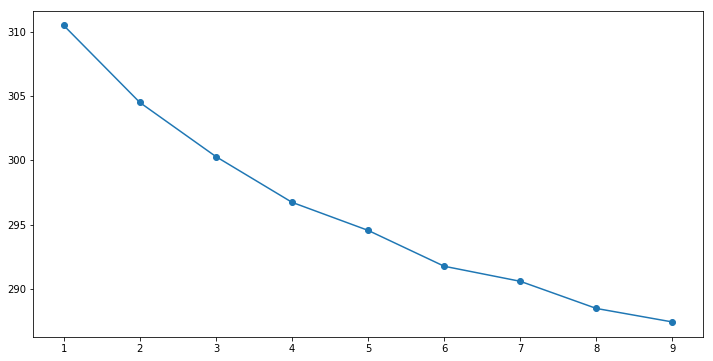

In [298]:
plt.figure(figsize=(12,6))
plt.plot(clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o");

In [116]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters, n_jobs=7, n_init=10, max_iter=300)
km.fit(dense_corpus.T)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=7, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

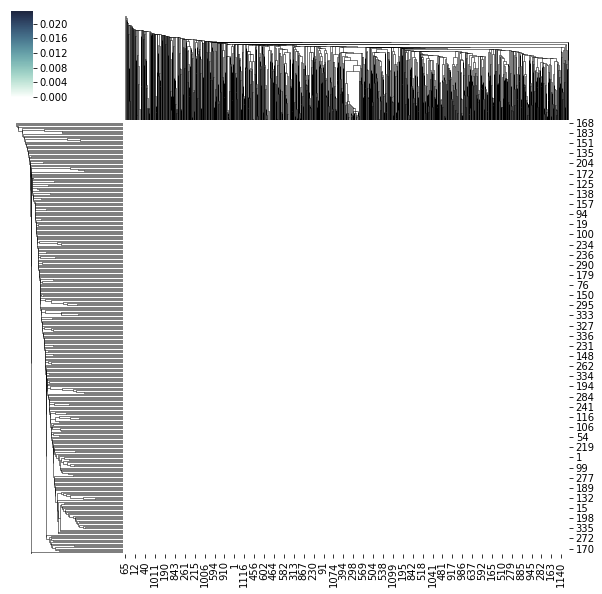

In [174]:
import seaborn as sn
cmap = sn.cubehelix_palette(as_cmap=True, rot=-.3, light=1)
sn.clustermap(dense_corpus, cmap=cmap, linewidths=.5, metric="cosine", method="average");